In [219]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib_inline
from ydata_profiling import ProfileReport

import json
from enum import Enum

%matplotlib inline

plt.style.use(r'C:\LibsAndApps\Python config files\proplot_style.mplstyle')
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

Import election data from 2019:

In [366]:
df_c = pd.read_excel('real_data/HoC-GE2019-results-by-candidate.xlsx', sheet_name='Data', skiprows=2)
ProfileReport(df_c)

Preprocessing:

In [367]:
# put independent candidates into their own individual parties
ind = df_c['Party name'] == 'Independent'
df_c.loc[ind, 'Party name'] = 'Independent - ' + df_c.loc[ind, 'Candidate first name'] + ' ' + df_c.loc[ind, 'Candidate surname']

# absorb 'Labour and Cooperative' party into 'Labour'
df_c.loc[df_c['Party name'] == 'Labour and Co-operative', 'Party name'] = 'Labour'

# sum votes for each party
df_p = pd.DataFrame()
df_p = df_c.groupby('Party name').Votes.sum().reset_index()
df_p.sort_values('Votes', ascending=False, inplace=True, ignore_index=True)

NUM_SEATS = df_c['Constituency name'].nunique()

Calculate seats using First Past the Post (FPTP):

In [368]:
def calculate_FPTP(df_c, df_p):
    # identify winning party in each constituency
    df_fptp = pd.DataFrame()
    df_fptp = df_c.groupby('Constituency name').Votes.idxmax()
    df_fptp = df_c.loc[df_fptp, ['Constituency name', 'Party name']]
    df_fptp.rename(columns={'Party name': 'Winning party'}, inplace=True)

    results_fptp = {seat: party for seat, party in zip(df_fptp['Constituency name'], df_fptp['Winning party'])}
    seats_allocated_fptp = {party: df_fptp.loc[df_fptp['Winning party'] == party].shape[0] for party in df_p['Party name']}

    # calculate deviation from proportionality
    dv_fptp = 1/2 * sum([abs(df_p.loc[df_p['Party name'] == party, 'Votes'].values[0] / df_p['Votes'].sum() -
        seats_allocated_fptp[party] / NUM_SEATS) for party in seats_allocated_fptp.keys()])
    
    # proportion of conservative votes
    print(df_p.loc[df_p['Party name'] == 'Conservative', 'Votes'].values[0] / df_p['Votes'].sum())

    # remove parties with no seats from record
    seats_allocated_fptp = {party: seats for party, seats in seats_allocated_fptp.items() if seats > 0}
    
    return (results_fptp, seats_allocated_fptp, dv_fptp)
    
results_fptp, seats_allocated_fptp, dv_fptp = calculate_FPTP(df_c, df_p)

print('Results using FPTP:')
print(seats_allocated_fptp)
print(f'Deviation from proportionality: {dv_fptp:.2%}')
# decide results based on seats
# calculate working majority: 650 minus 1 speaker, 3 deputy speakers and the Sinn Fein MPs
working_majority_fptp = (NUM_SEATS - 4 - seats_allocated_fptp.get('Sinn Féin', 0)) // 2 + 1
if any([seats_allocated_fptp.get(party, 0) >= working_majority_fptp for party in seats_allocated_fptp.keys()]):
    winning_party_fptp = max(seats_allocated_fptp, key=seats_allocated_fptp.get)
    print(f'Result: {winning_party_fptp} wins, {seats_allocated_fptp[winning_party_fptp]} seats > {working_majority_fptp} working majority')
else:
    winning_party_fptp = None
    print(f'Coalition required: no party has the working majority of {working_majority_fptp} seats')


0.43625932440414555
Results using FPTP:
{'Conservative': 365, 'Labour': 202, 'Liberal Democrat': 11, 'Scottish National Party': 48, 'Green Party': 1, 'Democratic Unionist Party': 8, 'Sinn Féin': 7, 'Plaid Cymru': 4, 'Alliance': 1, 'Social Democratic & Labour Party': 2, 'Speaker': 1}
Deviation from proportionality: 17.22%
Result: Conservative wins, 365 seats > 320 working majority


Calculate seats using Proportional Past the Post (PPP):

In [369]:
def calculate_PPP(df_c, df_p):

    df_p['Quota'] = np.ceil(df_p['Votes'] / df_p['Votes'].sum() * NUM_SEATS)
    df_p['Quota'] = df_p['Quota'].astype(int)

    # calculate vote share in each constituency
    df_c['Vote Share'] = df_c.groupby('Constituency name')['Votes'].transform(lambda x: x / x.sum())
    df_c = df_c.sort_values(by='Vote Share', ascending=False)

    # allocate seats to each party
    results_ppp = {seat: None for seat in df_c['Constituency name'].unique()}
    seats_allocated_ppp = {party: 0 for party in df_p['Party name'].unique()}
    for _, row in df_c.iterrows():
        constituency = row['Constituency name']
        party = row['Party name']
        if results_ppp[constituency] is not None:  # constituency already allocated
            continue
        if seats_allocated_ppp[party] >= df_p.loc[df_p['Party name'] == party, 'Quota'].values[0]:  # party already met quota
            continue
        results_ppp[constituency] = party
        seats_allocated_ppp[party] += 1

    # any unallocated seats go to party with highest total vote
    leading_party = df_p.iloc[0, 0]
    num_nones = list(results_ppp.values()).count(None)
    results_ppp = {k: (v if v is not None else leading_party) for k, v in results_ppp.items()}
    seats_allocated_ppp[leading_party] += num_nones

    # calculate deviation from proportionality
    dv_ppp = 1/2 * sum([abs(df_p.loc[df_p['Party name'] == party, 'Votes'].values[0] / df_p['Votes'].sum() -
        seats_allocated_ppp[party] / NUM_SEATS) for party in seats_allocated_ppp.keys()])

    # remove parties with no seats from record
    seats_allocated_ppp = {k: v for k, v in seats_allocated_ppp.items() if v > 0}
    
    return (results_ppp, seats_allocated_ppp, dv_ppp)

results_ppp, seats_allocated_ppp, dv_ppp = calculate_PPP(df_c, df_p)

print('Results using PPP:')
print(seats_allocated_ppp)
print(f'Deviation from proportionality (PPP): {dv_ppp:.2%}')
# decide results based on seats
# calculate working majority: 650 minus 1 speaker, 3 deputy speakers and the Sinn Féin MPs
working_majority_ppp = (NUM_SEATS - 4 - seats_allocated_ppp.get('Sinn Féin', 0)) // 2 + 1
if any([seats_allocated_ppp.get(party, 0) >= working_majority_ppp for party in seats_allocated_ppp.keys()]):
    winning_party_ppp = max(seats_allocated_ppp, key=seats_allocated_ppp.get)
    print(f'Result: {winning_party_ppp} wins, {seats_allocated_ppp[winning_party_ppp]} seats > {working_majority_ppp} working majority')
else:
    winning_party_ppp = None
    print(f'Coalition required: no party has the working majority of {working_majority_ppp} seats')

Results using PPP:
{'Conservative': 290, 'Labour': 209, 'Liberal Democrat': 76, 'Scottish National Party': 26, 'Green Party': 6, 'The Brexit Party': 14, 'Democratic Unionist Party': 5, 'Sinn Féin': 4, 'Plaid Cymru': 4, 'Alliance': 3, 'Social Democratic & Labour Party': 3, 'Ulster Unionist Party': 2, 'The Yorkshire Party': 1, 'Speaker': 1, 'UK Independence Party': 1, 'Independent - David Gauke': 1, 'Ashfield Independents': 1, 'The Independent Group for Change': 1, 'Aontú': 1, 'Independent - Nicky Cockburn': 1}
Deviation from proportionality (PPP): 2.64%
Coalition required: no party has the working majority of 322 seats


Calculate seats using Proportional Representation (PR):

In [370]:
class PR_Method(Enum):
    D_HONDT = 1
    SAINT_LAGUE = 2


def calculate_PR(df_p, num_seats=NUM_SEATS, method=PR_Method.D_HONDT):

    # constituencies are not used in PR - only the total votes are used to form the results
    df_p['Seats_PR'] = 0
    seats_allocated_pr = {party: 0 for party in df_p['Party name'].unique()}

    match method:
        case PR_Method.D_HONDT:
            divisor = 1
        case PR_Method.SAINT_LAGUE:
            divisor = 2

    for _ in range(num_seats):
        df_p['Quotient'] = (df_p['Votes'] / (divisor * df_p['Seats_PR'] + 1)).astype(int)
        winner = df_p.loc[df_p['Quotient'].idxmax(), 'Party name']
        seats_allocated_pr[winner] += 1
        df_p.loc[df_p['Party name'] == winner, 'Seats_PR'] += 1

    # calculate deviation from proportionality
    dv_pr = 1/2 * sum([abs(df_p.loc[df_p['Party name'] == party, 'Votes'].values[0] / df_p['Votes'].sum() -
        seats_allocated_pr[party] / num_seats) for party in seats_allocated_pr.keys()])

    # remove parties with no seats from record
    seats_allocated_pr = {k: v for k, v in seats_allocated_pr.items() if v > 0}
    
    return (seats_allocated_pr, dv_pr)

seats_allocated_pr, dv_pr = calculate_PR(df_p, method=PR_Method.SAINT_LAGUE)

print(f'Results using PR (Sainte-Laguë method)')  # Sainte-Laguë or d'Hondt
print(seats_allocated_pr)
print(f'Deviation from proportionality (PR): {dv_pr:.2%}')
# decide results based on seats
# calculate working majority: 650 minus 1 speaker, 3 deputy speakers and the Sinn Féin MPs
working_majority_pr = (NUM_SEATS - 4 - seats_allocated_pr.get('Sinn Féin', 0)) // 2 + 1
if any([seats_allocated_pr.get(party, 0) >= working_majority_pr for party in seats_allocated_pr.keys()]):
    winning_party_pr = max(seats_allocated_pr, key=seats_allocated_pr.get)
    print(f'Result: {winning_party_pr} wins, {seats_allocated_pr[winning_party_pr]} seats > {working_majority_pr} working majority')
else:
    winning_party_pr = None
    print(f'Coalition required: no party has the working majority of {working_majority_pr} seats')

Results using PR (Sainte-Laguë method)
{'Conservative': 286, 'Labour': 210, 'Liberal Democrat': 76, 'Scottish National Party': 25, 'Green Party': 18, 'The Brexit Party': 13, 'Democratic Unionist Party': 5, 'Sinn Féin': 4, 'Plaid Cymru': 3, 'Alliance': 3, 'Social Democratic & Labour Party': 2, 'Ulster Unionist Party': 2, 'The Yorkshire Party': 1, 'Speaker': 1, 'Independent - Claire Wright': 1}
Deviation from proportionality (PR): 1.14%
Coalition required: no party has the working majority of 322 seats


Plots:

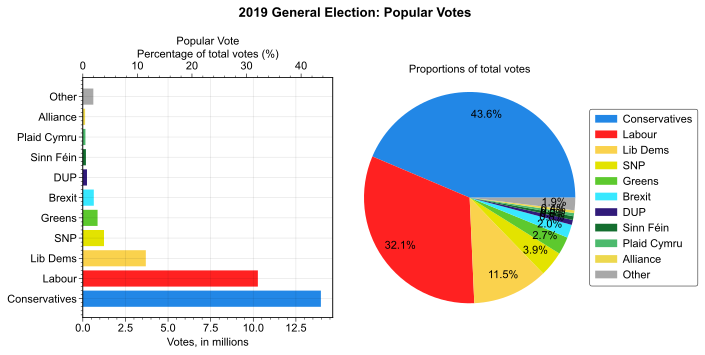

In [371]:
num_top = 10
top = df_p.head(num_top)
top = pd.concat([top, pd.DataFrame([['Other', df_p.loc[num_top:, 'Votes'].sum()]],
    columns=['Party name', 'Votes'])], ignore_index=True)

keys = json.load(open('main_parties.json'))

def name(party: str) -> str:
    if party in keys:
        return keys[party]['name']
    if 'Independent - ' in party:
        return party.split(' - ')[-1]
    if len(party.split()) >= 3:
        return ''.join([word[0].upper() for word in party.split()])
    if len(party) > 18:
        return party[:15] + '...'
    return party


fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.barh([name(p) for p in top['Party name']], top['Votes'] / 1e6,
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in top['Party name']])
ax1.set_xlabel('Votes, in millions')
ax1.set_title('Popular Vote')
ax1t = ax1.twiny()
ax1t.barh([name(p) for p in top['Party name']], top['Votes'] / top['Votes'].sum() * 100,
    color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in top['Party name']], alpha=0)
ax1t.grid(False)
ax1t.set_xlabel('Percentage of total votes (%)')

ax2.pie(top['Votes'],
    colors=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in top['Party name']],
    radius=1.1, autopct='%1.1f%%', pctdistance=0.8)
ax2.legend([name(p) for p in top['Party name']], loc='center left', bbox_to_anchor=(1, 0.5))
ax2.set_title('Proportions of total votes')

fig1.suptitle('2019 General Election: Popular Votes')
fig1.tight_layout()
fig1.savefig('figures/2019_general_election_popular_votes.svg')
plt.show()

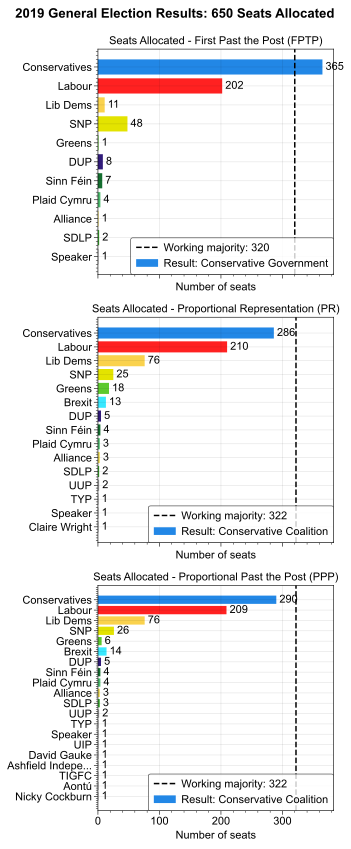

In [372]:
fig2, (ax3, ax4, ax5) = plt.subplots(3, 1, figsize=(5, 12), sharex=True)

ax3.barh([name(p) for p in seats_allocated_fptp.keys()],
    seats_allocated_fptp.values(), color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in seats_allocated_fptp.keys()])
ax3.set_xlabel('Number of seats')
ax3.set_title('Seats Allocated - First Past the Post (FPTP)')
ax3.invert_yaxis()
for i, (party, seats) in enumerate(seats_allocated_fptp.items()):
    ax3.text(seats + 5, i, f'{seats}', va='center', ha='left')
ax3.axvline(working_majority_fptp, color='black', linestyle='--', label=f'Working majority: {working_majority_fptp}')
if winning_party_fptp is not None:
    ax3.barh([name(winning_party_fptp)], [1], color=[keys[winning_party_fptp]['colour']], label=f'Result: {winning_party_fptp} Government')
else:
    leading_party_fptp = max(seats_allocated_fptp, key=seats_allocated_fptp.get)
    ax3.barh([name(leading_party_fptp)], [1], color=[keys[leading_party_fptp]['colour']], label=f'Result: {leading_party_fptp} Coalition')
ax3.legend()

ax4.barh([name(p) for p in seats_allocated_pr.keys()],
    seats_allocated_pr.values(), color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in seats_allocated_pr.keys()])
ax4.set_xlabel('Number of seats')
ax4.set_title('Seats Allocated - Proportional Representation (PR)')
ax4.invert_yaxis()
for i, (party, seats) in enumerate(seats_allocated_pr.items()):
    ax4.text(seats + 5, i, f'{seats}', va='center', ha='left')
ax4.axvline(working_majority_pr, color='black', linestyle='--', label=f'Working majority: {working_majority_pr}')
if winning_party_pr is not None:
    ax4.barh([name(winning_party_pr)], [1], color=[keys[winning_party_pr]['colour']], label=f'Result: {winning_party_pr} Government')
else:
    leading_party_pr = max(seats_allocated_pr, key=seats_allocated_pr.get)
    ax4.barh([name(leading_party_pr)], [1], color=[keys[leading_party_pr]['colour']], label=f'Result: {leading_party_pr} Coalition')
ax4.legend()

ax5.barh([name(p) for p in seats_allocated_ppp.keys()],
    seats_allocated_ppp.values(), color=[keys[p]['colour'] if p in keys else '#a8a8a8' for p in seats_allocated_ppp.keys()])
ax5.set_xlabel('Number of seats')
ax5.set_title('Seats Allocated - Proportional Past the Post (PPP)')
ax5.invert_yaxis()
for i, (party, seats) in enumerate(seats_allocated_ppp.items()):
    ax5.text(seats + 5, i, f'{seats}', va='center', ha='left')
ax5.axvline(working_majority_ppp, color='black', linestyle='--', label=f'Working majority: {working_majority_ppp}')
if winning_party_ppp is not None:
    ax5.barh([name(winning_party_ppp)], [1], color=[keys[winning_party_ppp]['colour']], label=f'Result: {winning_party_ppp} Government')
else:
    leading_party_ppp = max(seats_allocated_ppp, key=seats_allocated_ppp.get)
    ax5.barh([name(leading_party_ppp)], [1], color=[keys[leading_party_ppp]['colour']], label=f'Result: {leading_party_ppp} Coalition')
ax5.legend()

fig2.suptitle('2019 General Election Results: 650 Seats Allocated')
fig2.tight_layout(rect=[0, 0, 1, 0.99])
fig2.savefig('figures/2019_general_election_results.svg')
plt.show()

Calculate proportionality for each top party for each system:

C:\Users\lnick\AppData\Local\Temp\ipykernel_9336\3664300177.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['_'] + [name(n) for n in df_p['Party name']], ha='center')


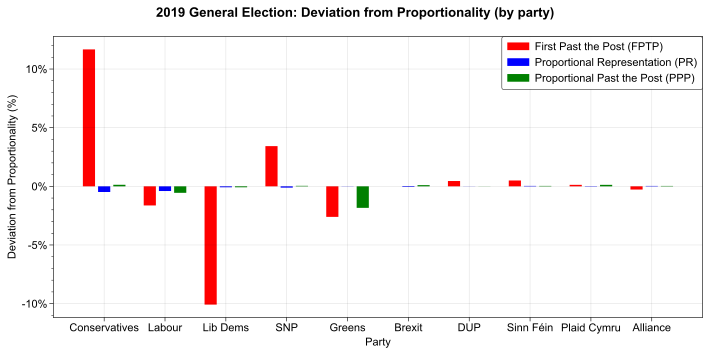

In [382]:
df_p['Votes %'] = df_p['Votes'] / df_p['Votes'].sum()
df_p['% S-V FPTP'] = df_p['Party name'].map(seats_allocated_fptp) / NUM_SEATS - df_p['Votes %']
df_p['% S-V PR'] = df_p['Party name'].map(seats_allocated_pr) / NUM_SEATS - df_p['Votes %']
df_p['% S-V PPP'] = df_p['Party name'].map(seats_allocated_ppp) / NUM_SEATS - df_p['Votes %']
df_p.fillna(0, inplace=True)
df_p = df_p[df_p['Party name'].isin(top['Party name'])]


fig3, ax = plt.subplots(figsize=(10, 5))
x = np.arange(0, df_p.shape[0], 1)
ax.bar(x - 0.25, df_p['% S-V FPTP'], color='red',
    label='First Past the Post (FPTP)', width=0.2)
ax.bar(x, df_p['% S-V PR'], color='blue',
    label='Proportional Representation (PR)', width=0.2)
ax.bar(x + 0.25, df_p['% S-V PPP'], color='green',
    label='Proportional Past the Post (PPP)', width=0.2)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.xaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xticklabels(['_'] + [name(n) for n in df_p['Party name']], ha='center')
ax.xaxis.set_minor_locator(plt.NullLocator())
ax.set_xlabel('Party')
ax.set_ylabel('Deviation from Proportionality (%)')
ax.legend()
fig3.suptitle('2019 General Election: Deviation from Proportionality (by party)')
fig3.tight_layout()
fig3.savefig('figures/2019_general_election_deviation.svg')

plt.show()


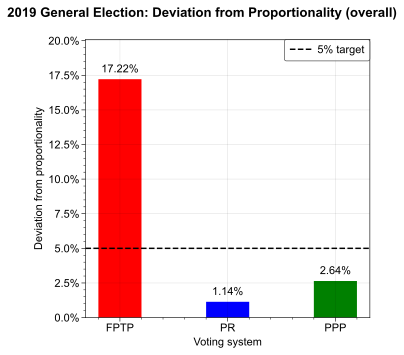

In [385]:
fig4, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.bar(['FPTP', 'PR', 'PPP'], [dv_fptp, dv_pr, dv_ppp], color=['red', 'blue', 'green'], width=0.4)
ax.axhline(0.05, color='black', linestyle='--', label='5% target')
ax.set_xlabel('Voting system')
ax.set_ylabel('Deviation from proportionality')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1%}'))
for i, dv in enumerate([dv_fptp, dv_pr, dv_ppp]):
    ax.text(i, dv + 0.005, f'{dv:.2%}', ha='center')
ax.set_ylim(top=ax.get_ylim()[1] + 0.02)
ax.legend()

fig4.suptitle('2019 General Election: Deviation from Proportionality (overall)')
fig4.tight_layout()
fig4.savefig('figures/2019_general_election_proportionality.svg')
plt.show()
